# Imports
The following packages are used:
1. numpy
2. tensorflow
3. matplotlib
4. tqdm

In [1]:
#pip install wandb


In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:

import wandb

In [4]:
wandb.login(key="eeeeee")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dayaalex. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/dalex/.netrc


True

# Data
Due to the fact that we want a minimal implementation of CBOW we will use a small corpus.

In [5]:
data = """
My name is Emma. Your name is Gloria. Gloria loves watching TV.
Gloria also loves gardening. Emma only loves reading books. Emma likes drama novels.
Gloria likes fruit bearing plants and trees. Gloria knows to tap dance. Emma is bad in sports.
Gloria plays cricket well. Emma hates cricket.
"""

In [6]:
# Converts the data into tokens
tokenized_text = tf.keras.preprocessing.text.text_to_word_sequence(data)
tokenized_text_size = len(tokenized_text)
# Creates a vocab of unique words
vocab = sorted(set(tokenized_text))
vocab_size = len(vocab)
print('Vocab Size: {}'.format(len(vocab)))

Vocab Size: 33


In [7]:
print(vocab)

['also', 'and', 'bad', 'bearing', 'books', 'cricket', 'dance', 'drama', 'emma', 'fruit', 'gardening', 'gloria', 'hates', 'in', 'is', 'knows', 'likes', 'loves', 'my', 'name', 'novels', 'only', 'plants', 'plays', 'reading', 'sports', 'tap', 'to', 'trees', 'tv', 'watching', 'well', 'your']


In [8]:
def check_in_vocab(word:str, vocab:list) -> bool:
  """Checks whether a word is in the vocab

  Arguments:
    word (str): The word to check

  Returns:
    bool: Returns whether the word is in the vocab or not
  """
  return word in vocab

In [9]:
print(check_in_vocab("Gloria", vocab))
print(check_in_vocab("gloria", vocab))

False
True


In [10]:
# Map the vocab words to individual indices
vocab_to_ix = {c:ix for ix,c in enumerate(vocab)}
# Map the indices to the words in vocab
ix_to_vocab = np.array(vocab)
# Convert the data into numbers
text_as_int = np.array([vocab_to_ix[c] for c in tokenized_text])

In [11]:
print(vocab_to_ix)
print(ix_to_vocab)
print(text_as_int)

{'also': 0, 'and': 1, 'bad': 2, 'bearing': 3, 'books': 4, 'cricket': 5, 'dance': 6, 'drama': 7, 'emma': 8, 'fruit': 9, 'gardening': 10, 'gloria': 11, 'hates': 12, 'in': 13, 'is': 14, 'knows': 15, 'likes': 16, 'loves': 17, 'my': 18, 'name': 19, 'novels': 20, 'only': 21, 'plants': 22, 'plays': 23, 'reading': 24, 'sports': 25, 'tap': 26, 'to': 27, 'trees': 28, 'tv': 29, 'watching': 30, 'well': 31, 'your': 32}
['also' 'and' 'bad' 'bearing' 'books' 'cricket' 'dance' 'drama' 'emma'
 'fruit' 'gardening' 'gloria' 'hates' 'in' 'is' 'knows' 'likes' 'loves'
 'my' 'name' 'novels' 'only' 'plants' 'plays' 'reading' 'sports' 'tap'
 'to' 'trees' 'tv' 'watching' 'well' 'your']
[18 19 14  8 32 19 14 11 11 17 30 29 11  0 17 10  8 21 17 24  4  8 16  7
 20 11 16  9  3 22  1 28 11 15 27 26  6  8 14  2 13 25 11 23  5 31  8 12
  5]


In [12]:
wandb.init(entity="dayaalex", project="embeddings", name="CBOW")

# Model parameters

In [13]:
EMBEDDING_SIZE = 2
WINDOW_SIZE = 5
opt = tf.optimizers.legacy.Adam()
iterations = 1000
# Here the word vectors are represented as row
context_vector =  tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))
center_vector = tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))

2023-09-17 15:50:07.280015: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-17 15:50:07.280076: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-17 15:50:07.280091: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-17 15:50:07.280640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-17 15:50:07.281129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Implemetation

In [14]:
def train_step(indices, loss_list):
  """The training step

  Arguments:
    indices (list): The indices of the vocab in the window
  """
  with tf.GradientTape() as tape:
    # Context
    u_avg = 0
    for count,index in enumerate(indices):
      if count != WINDOW_SIZE//2:
        u_avg += context_vector[index,:]
    u_avg /= WINDOW_SIZE-1
    # Center
    output = tf.matmul(center_vector, tf.expand_dims(u_avg ,1))
    soft_out = tf.nn.softmax(output, axis=0)
    loss = soft_out[indices[WINDOW_SIZE//2]]
    log_loss = -tf.math.log(loss)
    wandb.log({"loss":log_loss.numpy()})
  loss_list.append(log_loss.numpy())
  grad = tape.gradient(log_loss, [context_vector, center_vector])
  opt.apply_gradients(zip(grad, [context_vector, center_vector]))

In [17]:
loss_list = []
for iter in tqdm(range(iterations)):
  # Creation of window
  for start in range(tokenized_text_size-WINDOW_SIZE):
    indices = text_as_int[start:start+WINDOW_SIZE]
    train_step(indices, loss_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


InvalidArgumentError: Cannot assign a device for operation ResourceApplyAdam: Could not satisfy explicit device specification '/job:localhost/replica:0/task:0/device:GPU:0' because no supported kernel for GPU devices is available.
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=1 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
ResourceApplyAdam: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  var (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  m (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  v (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  ResourceApplyAdam (ResourceApplyAdam) /job:localhost/replica:0/task:0/device:GPU:0

Op: ResourceApplyAdam
Node attrs: T=DT_DOUBLE, use_nesterov=false, use_locking=true
Registered kernels:
  device='XLA_CPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_COMPLEX128]

	 [[{{node ResourceApplyAdam}}]] [Op:ResourceApplyAdam] name: 

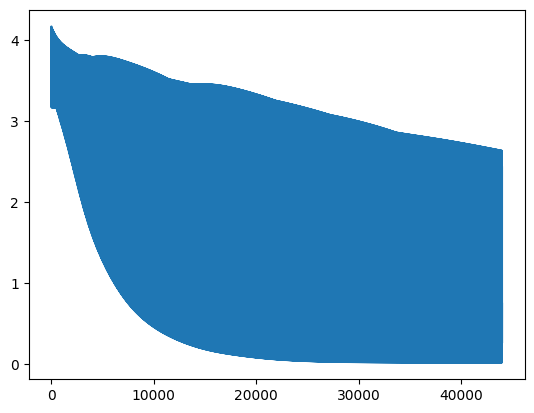

In [ ]:
plt.plot(loss_list)

Error: plotly is required to log interactive plots, install with: `pip install plotly` or convert the plot to an image with `wandb.Image(plt)`

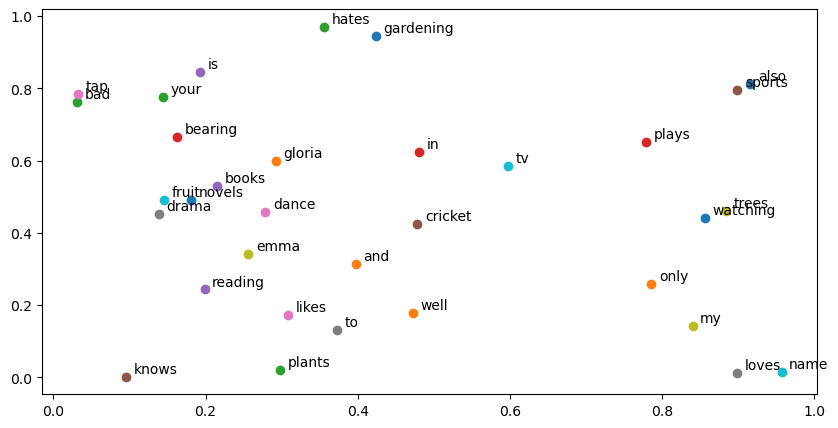

In [18]:


center_vector.numpy().shape
fig = plt.figure(figsize=(10,5))
count = 0
for i,j in center_vector.numpy():
  plt.scatter(i,j)
  plt.text( i+0.01, j+0.01, ix_to_vocab[count])
  count += 1
wandb.log({"Center Word Embeddings": fig})
plt.show()

